Installing necessary prereqs: [NetworkX](https://networkx.org/documentation/stable/reference/index.html) for graphing, [PuLP](https://coin-or.github.io/pulp/main/index.html) for linear programming.

In [41]:
%pip install networkx pulp

Note: you may need to restart the kernel to use updated packages.


In [42]:

import json
import networkx as nx

file = open("map_ia.json")
data = json.load(file)

adjacencies = data["adj"]
countyNames = data["county"]
pop = data["pop"]

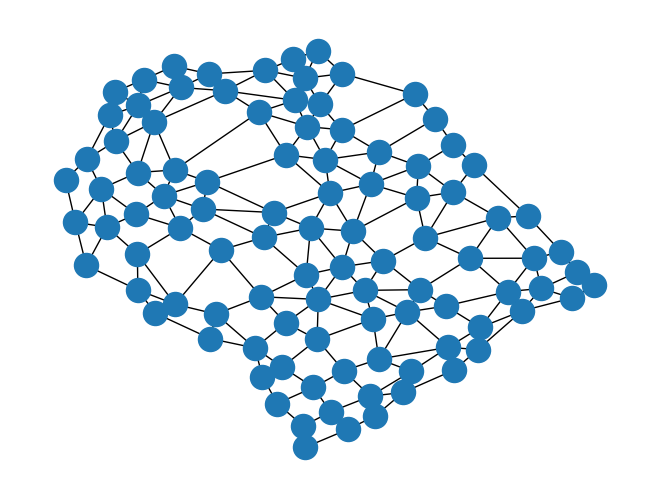

In [43]:
from random import Random

stateGraph = nx.Graph()

r =  Random(51535162)
totalPop = 0
# Add the nodes as necessary

for i in range(0, len(adjacencies)):
    # Adds node for each set of adjacencies
    stateGraph.add_node(countyNames[i], weight=pop[i])
    totalPop += pop[i]
    # Adds necessary edges; double-adding doesn't matter
    for j in adjacencies[i]:
        # Add edge with uniformly random weight 0, 10
        stateGraph.add_edge(countyNames[i], countyNames[j], weight=r.uniform(0, 10))

nx.draw(stateGraph)

In [44]:
# Number of districts
NUM_DISTRICTS = 4

# Population Tolerance
ALPHA = .05

# Population per district
targetPop = totalPop / NUM_DISTRICTS

# Binary indicators, defined as 1 if in node in same partitition as 
# source S or 0 in same as sink O. Initializes to 0.
V = [0 for i in range(stateGraph.order())]

# 
Y = [[0 for i in range(stateGraph.order())] for j in range(stateGraph.order())]


In [50]:
import pulp 

def CutPartition(remainingGraph):
    prog = pulp.LpProblem("CutPartition", pulp.LpMinimize)

    # Defining Partition Binary
    xVars = []
    xVarMap = {}
    for n in remainingGraph.nodes:
        var = pulp.LpVariable("x" + n, cat=pulp.LpBinary)
        xVarMap[n] = var
        xVars.append(var)
        prog += var
    # Defining crossing binary
    edgeVars = []
    weights = []
    for n, m in remainingGraph.edges:
        edgeVal = pulp.LpAffineExpression([(xVarMap[n], 1), (xVarMap[m], -1)])
        absEdgeVal = pulp.LpVariable('y' + n + m, cat=pulp.LpBinary)

        # Tries to fix absolute value prob
        prog += absEdgeVal >= edgeVal
        prog += absEdgeVal >= -edgeVal

        edgeVars.append(absEdgeVal)
        weights.append(remainingGraph[n][m]['weight'])
    # Subset sum
    popVariables = []
    for i in range(len(xVars)):
        popVariables.append(pulp.LpAffineExpression(xVars[i] * pop[i]))
    # Max Pop
    prog += pulp.lpSum(popVariables) <= targetPop * (1 + ALPHA)
    # Min Pop
    prog += pulp.lpSum(popVariables) >= targetPop * (1 - ALPHA)

    # Define Minimization Target
    # Edgeweights
    edgeWeightVars = []
    for i in range(len(edgeVars)):
        edgeWeightVars.append(pulp.LpAffineExpression(edgeVars[i] * weights[i]))
    prog += pulp.LpAffineExpression(pulp.lpSum(edgeWeightVars), name="Z")

    prog.solve()

    toReturn = {}

    districtPop = 0
    for i in range(len(xVars)):
        if(xVars[i].value() == 1):
            districtPop += pop[i]
            toReturn[xVars[i].name] = xVars[i].value()
            print(xVars[i].name, xVars[i].value())
    print(districtPop)
    return toReturn

In [51]:
remainingGraph = stateGraph.copy()
districts = []
while len(districts) < NUM_DISTRICTS:
    cutResult = CutPartition(remainingGraph)
    newDistrict = []
    for d in cutResult.keys():
        newDistrict.append(d[1:])
    districts.append(newDistrict)
    remainingGraph.remove_nodes_from(newDistrict)
    print(newDistrict)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z3/3qb7cv41693fmz3b6hbntjkr0000gn/T/27a02ced72264154aa35ee0f8c2a9d9b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/z3/3qb7cv41693fmz3b6hbntjkr0000gn/T/27a02ced72264154aa35ee0f8c2a9d9b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 451 COLUMNS
At line 2846 RHS
At line 3293 BOUNDS
At line 3615 ENDATA
Problem MODEL has 446 rows, 321 columns and 1530 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 445 rows, 321 columns (321 integer (321 of which binary)) and 1431 elements
Cbc0038I Initial state - 99 integers unsatisfied sum - 23.5125
Cbc0038I Pass   1: suminf.    2.08522 (6) obj. 56.3439 iterati

In [55]:
import csv

file = open('ia_districts.csv', 'w')
w = csv.writer(file)
w.writerows(districts)
file.close()